In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

In [31]:
from typing import List, Union, Optional
import lmfit as lm
from dat_analysis import get_dat, get_dats
from dat_analysis.analysis_tools import nrg
from dat_analysis.analysis_tools.general_fitting import calculate_fit, FitInfo
from dat_analysis.useful_functions import mean_data, get_data_index
from dat_analysis.plotting.mpl.util import make_axes, ax_setup
from dat_analysis.plotting.mpl.plots import display_2d, waterfall_plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib as mpl
from dataclasses import dataclass
import numpy as np
import datetime
DELTA = '\u0394'

In [3]:
%matplotlib inline
mpl.rcParams.update({
    'figure.figsize': (6.4,4.8),
    'figure.dpi': 110,  # 27in 1440p = 110
})
print(f'Notebook last run on {datetime.date.today()}')

Notebook last run on 2022-04-01


# Introduction

Comparing the $dN/dT$ from NRG calculations where $\Delta T = 1\%$, to $\Delta N/ \Delta T$ with a $\Delta T = >30\%$ to check that there isn't a significant mismatch between NRG calculations and measurement. 

Using NRG data with fixed $\Gamma = 0.001$ and varying $T$ in order to generate the $\Delta N/\Delta T$ data. 

# Loading Data

In [32]:
    nrg_data = nrg.NRGData.from_old_mat()
    print(f'nrg_data keys are {nrg_data.__dict__.keys()}')
    print(f'All Gs == 0.001 in this nrg_data ({np.all([g == 0.001 for g in nrg_data.gs])})')
    gamma = nrg_data.gs[0]
    print(f'Ens are the same for every row of nrg_data ({np.all(np.all([ens == nrg_data.ens[0] for ens in nrg_data.ens]))})')
ens = nrg_data.ens[0]

nrg_data keys are dict_keys(['ens', 'ts', 'conductance', 'dndt', 'entropy', 'occupation', 'int_dndt', 'gs'])
All Gs == 0.001 in this nrg_data (True)
Ens are the same for every row of nrg_data (True)


C:\Users\Child\AppData\Local\Temp/ipykernel_32224/899266613.py:1: DeprecatedWarning:

from_old_mat is deprecated. Use "from_new_mat" instead



Just loading the data that was sent in a `.mat` file. Note that the ens were sent as a 2D array, but the x-axis is the same for each row of data so I'm just using the first 1D array. 

Also, the Gs are a 1D array, but every value is 0.001 because this data was calculated with fixed $\Gamma$ varying $T$ where the newer data is the opposite.

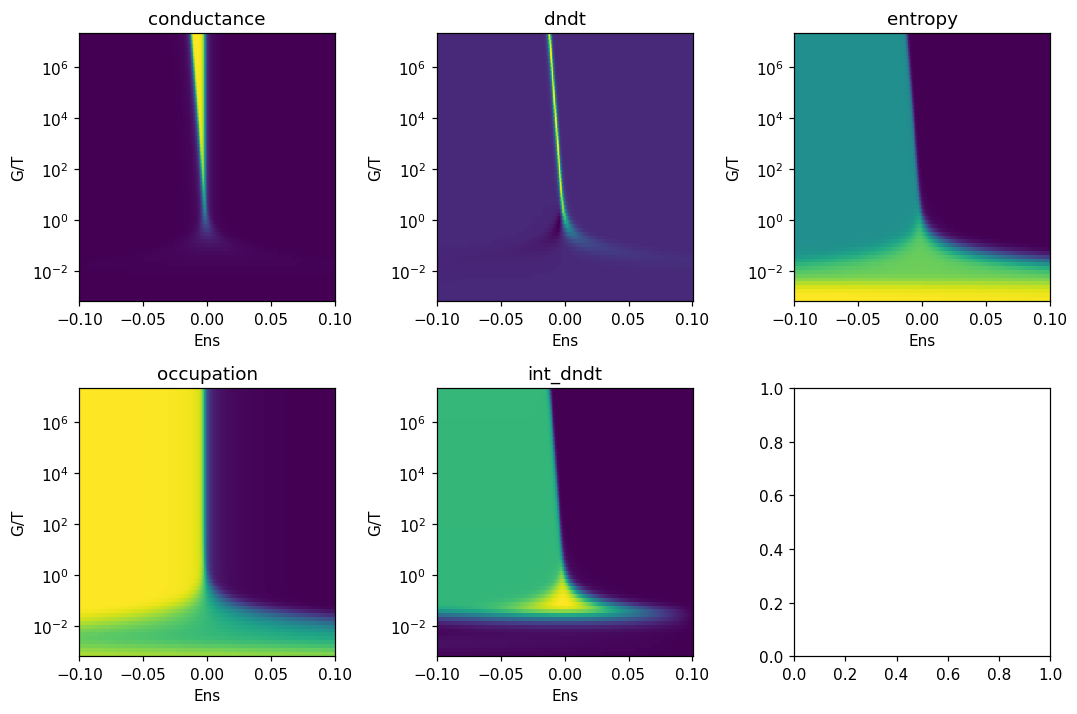

In [13]:
keys_2d = ['conductance', 'dndt', 'entropy', 'occupation', 'int_dndt']

fig, axs = make_axes(len(keys_2d))

for key, ax in zip(keys_2d, axs):
    x = ens
    y = nrg_data.gs/nrg_data.ts
    data = nrg_data.__getattribute__(key)
    ax.pcolormesh(x, y, data, shading='auto')
    ax.set_yscale('log')#     display_2d(x, y, data.__getattribute__(key), ax, colorscale=True, x_label='Ens', y_label='G/T')
    ax.set_xlabel('Ens')
    ax.set_ylabel('G/T')
    ax.set_title(key)
fig.tight_layout()
    
    

# Generating $\Delta N/\Delta T$

Will do this by subtracting consecutive rows of Occupation, $N$, data. Note that the T scale is log spaced, and so the $\Delta T$ between consecutive rows is always $\sim 40\%$

In [25]:
ts =  nrg_data.ts
diffs = (ts[1:] - ts[:-1])/ts[:-1]
mean_diff = np.mean(diffs)
print(f'All differences are close to the mean_diff of {mean_diff*100:.3g}% ({np.all(np.isclose(diffs, mean_diff, atol=0.01))})')


All differences are close to the mean_diff of 41.4% (True)


In [27]:
occ = nrg_data.occupation
DnDt = occ[1:] - occ[:-1]  # Just subtract subsequent rows

(69, 401)

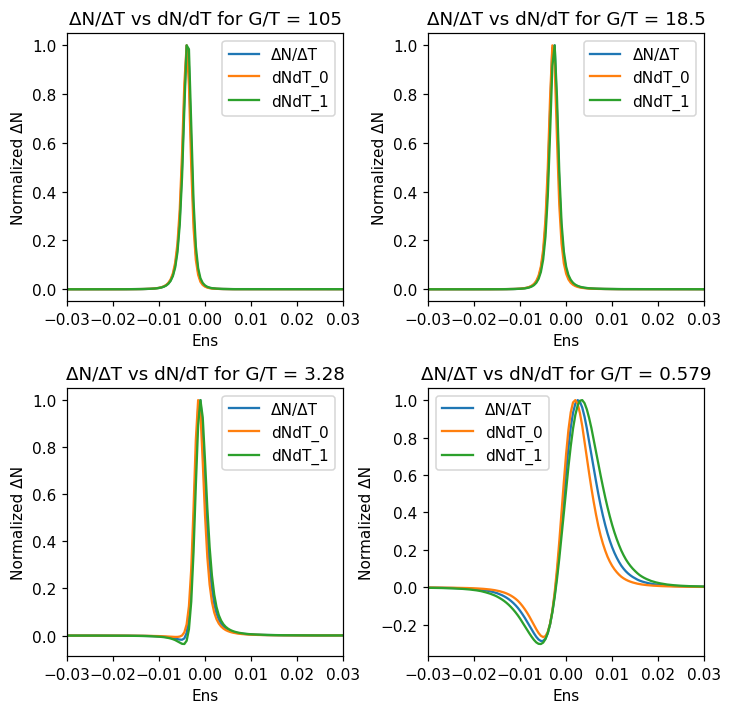

In [43]:
rows = [35, 40, 45, 50]
fig, axs = make_axes(len(rows))
for row, ax in zip(rows, axs):
    x = ens
    t = ts[row]
    deltaNT = DnDt[row]
    dndt_0 = nrg_data.dndt[row]
    dndt_1 = nrg_data.dndt[row+1]
    # Normalize all the datas
    deltaNT, dndt_0, dndt_1 = (arr/np.nanmax(arr) for arr in [deltaNT, dndt_0, dndt_1])
    ax.plot(x, deltaNT, label=f'{DELTA}N/{DELTA}T')
    ax.plot(x, dndt_0, label=f'dNdT_0')
    ax.plot(x, dndt_1, label=f'dNdT_1')
    ax.set_title(f'{DELTA}N/{DELTA}T vs dN/dT for G/T = {gamma/t:.3g}')
    ax.set_xlabel('Ens')
    ax.set_ylabel(f'Normalized {DELTA}N')
    ax.set_xlim(-0.03, 0.03)
    ax.legend()
fig.tight_layout()

In the higher G/T limit, the difference between finite $\Delta T = 41\%$ and the small $dT = 1\%$ (for NRG $dN/dT$) data is very small. And as expected, the finite $\Delta T$ lies between the two consecutive $dN/dT$ curves.  
In the weakly coupled - thermally broadened - regime, the difference is more noticeable, however, it remains true that the finite $\Delta T$ lies between the NRG $dN/dT$ curves.

Therefore, the experimental $\Delta T \sim 30\%$ should not be a problem. 